## Market Basket Analysis using FP-growth

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

# Import Data
aisles = spark.read.csv("hdfs://namenode/aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("hdfs://namenode/departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv("hdfs://namenode/order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv("hdfs://namenode/order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv("hdfs://namenode/orders.csv", header=True, inferSchema=True)
products = spark.read.csv("hdfs://namenode/products.csv", header=True, inferSchema=True)

# Create Temporary Tables
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

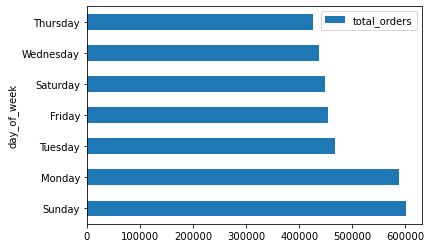

In [4]:
# Orders by Day of Week
results = spark.sql(" \
    select \
      count(order_id) as total_orders, \
      (case \
         when order_dow = '0' then 'Sunday' \
         when order_dow = '1' then 'Monday' \
         when order_dow = '2' then 'Tuesday' \
         when order_dow = '3' then 'Wednesday' \
         when order_dow = '4' then 'Thursday' \
         when order_dow = '5' then 'Friday' \
         when order_dow = '6' then 'Saturday' end) as day_of_week \
    from orders  \
    group by order_dow \
    order by total_orders desc")

df_pandas = results.toPandas()
df_pandas.plot(kind='barh',x='day_of_week',y='total_orders')

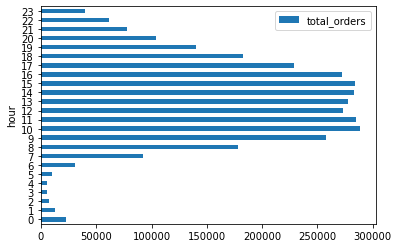

In [5]:
# Orders by Hour
results = spark.sql(" \
    select \
        count(order_id) as total_orders, \
        order_hour_of_day as hour \
        from orders \
    group by order_hour_of_day \
    order by order_hour_of_day \
                    ")

df_pandas = results.toPandas()
df_pandas.plot(kind='barh',x='hour',y='total_orders')

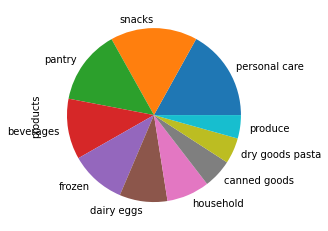

In [6]:
# Understand shelf space by department
results = spark.sql("  \
    select d.department, count(distinct p.product_id) as products \
        from products p \
              inner join departments d \
                  on d.department_id = p.department_id \
    group by d.department \
    order by products desc \
    limit 10 \
                    ")

df_pandas = results.toPandas()
df_pandas.plot(kind='pie', y='products', labels=df_pandas['department'], legend = False)

##  Organize Shopping Basket

In [7]:
from pyspark.sql.functions import collect_set, col, count

rawData = spark.sql("  \
    select p.product_name, o.order_id  \
    from products p inner join order_products_train o  \
    where o.product_id = p.product_id \
                    ") 
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.show(10)

+--------+--------------------+
|order_id|               items|
+--------+--------------------+
|    1342|[Raw Shrimp, Seed...|
|    1591|[Cracked Wheat, S...|
|    4519|[Beet Apple Carro...|
|    4935|             [Vodka]|
|    6357|[Globe Eggplant, ...|
|   10362|[Organic Baby Spi...|
|   19204|[Reduced Fat Crac...|
|   29601|[Organic Red Onio...|
|   31035|[Organic Cripps P...|
|   40011|[Organic Baby Spi...|
+--------+--------------------+
only showing top 10 rows



## Train ML Model


In [8]:
from pyspark.ml.fpm import FPGrowth

baskets_ds = spark.sql("select items from baskets")

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0.0)
model = fpGrowth.fit(baskets_ds)

In [9]:
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

In [10]:
popular = spark.sql("  \
        select items, freq  \
        from mostPopularItemInABasket  \
        where size(items) > 2  \
        order by freq desc  \
        limit 20 \
                    ") 
popular.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[Organic Hass Avo...| 710|
|[Organic Raspberr...| 649|
|[Organic Baby Spi...| 587|
|[Organic Raspberr...| 531|
|[Organic Hass Avo...| 497|
|[Organic Avocado,...| 484|
|[Organic Avocado,...| 477|
|[Limes, Large Lem...| 452|
|[Organic Cucumber...| 424|
|[Limes, Organic A...| 389|
|[Organic Raspberr...| 381|
|[Organic Avocado,...| 379|
|[Organic Baby Spi...| 376|
|[Organic Blueberr...| 374|
|[Large Lemon, Org...| 371|
|[Organic Cucumber...| 366|
|[Organic Lemon, O...| 353|
|[Limes, Organic A...| 352|
|[Organic Whole Mi...| 339|
|[Organic Avocado,...| 334|
+--------------------+----+



In [11]:
ifThen = model.associationRules
ifThen.createOrReplaceTempView("ifThen")

In [12]:
# A good way to think about association rules is that 
# model determines that if you purchased something (i.e. the antecedent), 
# then you will purchase this other thing (i.e. the consequent) 
# with the following confidence.

antecedent  = spark.sql("  \
select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence  \
from ifThen \
order by confidence desc \
limit 20 \
                    ") 
antecedent.show()

+--------------------+--------------------+-------------------+
|     antecedent (if)|   consequent (then)|         confidence|
+--------------------+--------------------+-------------------+
|[Organic Raspberr...|[Bag of Organic B...| 0.5984251968503937|
|[Organic Cucumber...|[Bag of Organic B...|           0.546875|
|[Organic Kiwi, Or...|[Bag of Organic B...| 0.5459770114942529|
|[Organic Navel Or...|[Bag of Organic B...| 0.5412186379928315|
|[Yellow Onions, S...|            [Banana]| 0.5357142857142857|
|[Organic Whole St...|[Bag of Organic B...| 0.5314685314685315|
|[Organic Navel Or...|[Bag of Organic B...| 0.5283018867924528|
|[Organic Raspberr...|[Bag of Organic B...|  0.521099116781158|
|[Organic D'Anjou ...|[Bag of Organic B...| 0.5170454545454546|
|[Organic Unsweete...|[Bag of Organic B...| 0.5141065830721003|
|[Organic Broccoli...|[Bag of Organic B...| 0.5048231511254019|
|[Organic Lemon, O...|[Bag of Organic B...| 0.4989106753812636|
|[Organic Hass Avo...|[Bag of Organic B.